<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [783]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [784]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-31 07:07:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-08-31 07:07:48 (210 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [785]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [786]:
df.shape

(346, 10)

### Convert to date time object


In [787]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [788]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [789]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



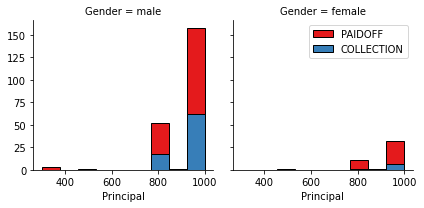

In [790]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

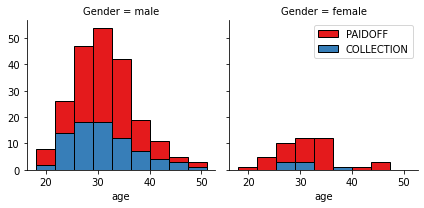

In [791]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


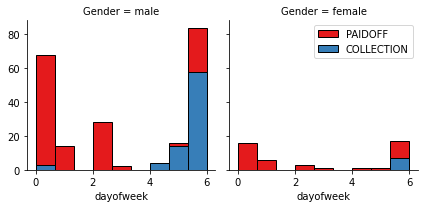

In [792]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [793]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [794]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [795]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [796]:
df['education'].replace(to_replace=['Bechalor','High School or Below','college','Master or Above'], value=[0,1,2,3],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,1,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,0,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,2,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,2,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,2,0,4,1


## One Hot Encoding

#### How about education?


In [797]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education  loan_status
0          PAIDOFF        0.750000
           COLLECTION     0.250000
1          PAIDOFF        0.741722
           COLLECTION     0.258278
2          PAIDOFF        0.765101
           COLLECTION     0.234899
3          COLLECTION     0.500000
           PAIDOFF        0.500000
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [798]:
df[['terms','age','Gender','education']].head()

,terms,age,Gender,education
0,30,45,0,1
1,30,33,1,0
2,15,27,0,2
3,30,28,1,2
4,30,29,0,2


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [799]:
Feature = df[['terms','age','Gender','education']]
# Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,terms,age,Gender,education
0,30,45,0,1
1,30,33,1,0
2,15,27,0,2
3,30,28,1,2
4,30,29,0,2


In [800]:
Feature['loan_status'] = df['loan_status']
Feature.head()

<ipython-input-800-305410ce6ed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Feature['loan_status'] = df['loan_status']


,terms,age,Gender,education,loan_status
0,30,45,0,1,PAIDOFF
1,30,33,1,0,PAIDOFF
2,15,27,0,2,PAIDOFF
3,30,28,1,2,PAIDOFF
4,30,29,0,2,PAIDOFF


### Feature Selection


Let's define feature sets, X:


In [801]:
X = Feature[['terms','age','Gender','education']]
X[0:4]

,terms,age,Gender,education
0,30,45,0,1
1,30,33,1,0
2,15,27,0,2
3,30,28,1,2


What are our lables?


In [802]:
y = Feature['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [803]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.92,  2.33, -0.42, -0.45],
       [ 0.92,  0.34,  2.38, -1.89],
       [-0.96, -0.65, -0.42,  0.99],
       [ 0.92, -0.49,  2.38,  0.99],
       [ 0.92, -0.32, -0.42,  0.99]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [804]:
Feature.head()

,terms,age,Gender,education,loan_status
0,30,45,0,1,PAIDOFF
1,30,33,1,0,PAIDOFF
2,15,27,0,2,PAIDOFF
3,30,28,1,2,PAIDOFF
4,30,29,0,2,PAIDOFF


In [805]:
cluster_data = Feature

In [806]:
cluster_data.head()

,terms,age,Gender,education,loan_status
0,30,45,0,1,PAIDOFF
1,30,33,1,0,PAIDOFF
2,15,27,0,2,PAIDOFF
3,30,28,1,2,PAIDOFF
4,30,29,0,2,PAIDOFF


In [807]:
tree_data['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

In [911]:
cluster_data.head()

,terms,age,Gender,education,loan_status
0,30,45,0,1,0
1,30,33,1,0,0
2,15,27,0,2,0
3,30,28,1,2,0
4,30,29,0,2,0


In [912]:
X_cluster = tree_data[['terms','age','Gender','education']]
X_cluster.head()

,terms,age,Gender,education
0,30,45,0,1
1,30,33,1,0
2,15,27,0,2
3,30,28,1,2
4,30,29,0,2


In [913]:
y_cluster = cluster_data['loan_status'].values
y_cluster[0:5]

array([0, 0, 0, 0, 0])

In [914]:
X_cluster = preprocessing.StandardScaler().fit(X_cluster).transform(X_cluster.astype(float))
X_cluster

array([[ 0.92,  2.33, -0.42, -0.45],
       [ 0.92,  0.34,  2.38, -1.89],
       [-0.96, -0.65, -0.42,  0.99],
       ...,
       [-0.96,  1.34, -0.42,  0.99],
       [ 0.92, -0.49, -0.42,  0.99],
       [ 0.92, -0.82, -0.42,  0.99]])

In [924]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_cluster, y_cluster, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 4) (276,)
Test set: (70, 4) (70,)


In [921]:
from sklearn.neighbors import KNeighborsClassifier

In [922]:
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [923]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 1, 0])

In [925]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7789855072463768
Test set Accuracy:  0.6714285714285714


In [926]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.54, 0.66, 0.6 , 0.67, 0.67, 0.67, 0.67, 0.67, 0.67])

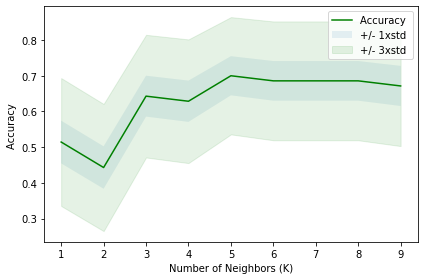

In [817]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [927]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6714285714285714 with k= 4


# Decision Tree


In [819]:
Feature.head()

,terms,age,Gender,education,loan_status
0,30,45,0,1,PAIDOFF
1,30,33,1,0,PAIDOFF
2,15,27,0,2,PAIDOFF
3,30,28,1,2,PAIDOFF
4,30,29,0,2,PAIDOFF


In [820]:
X_tree = Feature[['terms','age','Gender','education']]
X_tree[0:5]

,terms,age,Gender,education
0,30,45,0,1
1,30,33,1,0
2,15,27,0,2
3,30,28,1,2
4,30,29,0,2


In [821]:
y_tree = Feature['loan_status']
y_tree[0:5]

0    PAIDOFF
1    PAIDOFF
2    PAIDOFF
3    PAIDOFF
4    PAIDOFF
Name: loan_status, dtype: object

In [822]:
from sklearn.model_selection import train_test_split

In [823]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X_tree, y_tree, test_size=0.3, random_state=3)

In [824]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [825]:
loanTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [826]:
predTree = loanTree.predict(X_testset)

In [827]:
print (predTree [0:5])
print (y_testset [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
73        PAIDOFF
24        PAIDOFF
282    COLLECTION
295    COLLECTION
163       PAIDOFF
Name: loan_status, dtype: object


In [828]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.7307692307692307


In [829]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [830]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

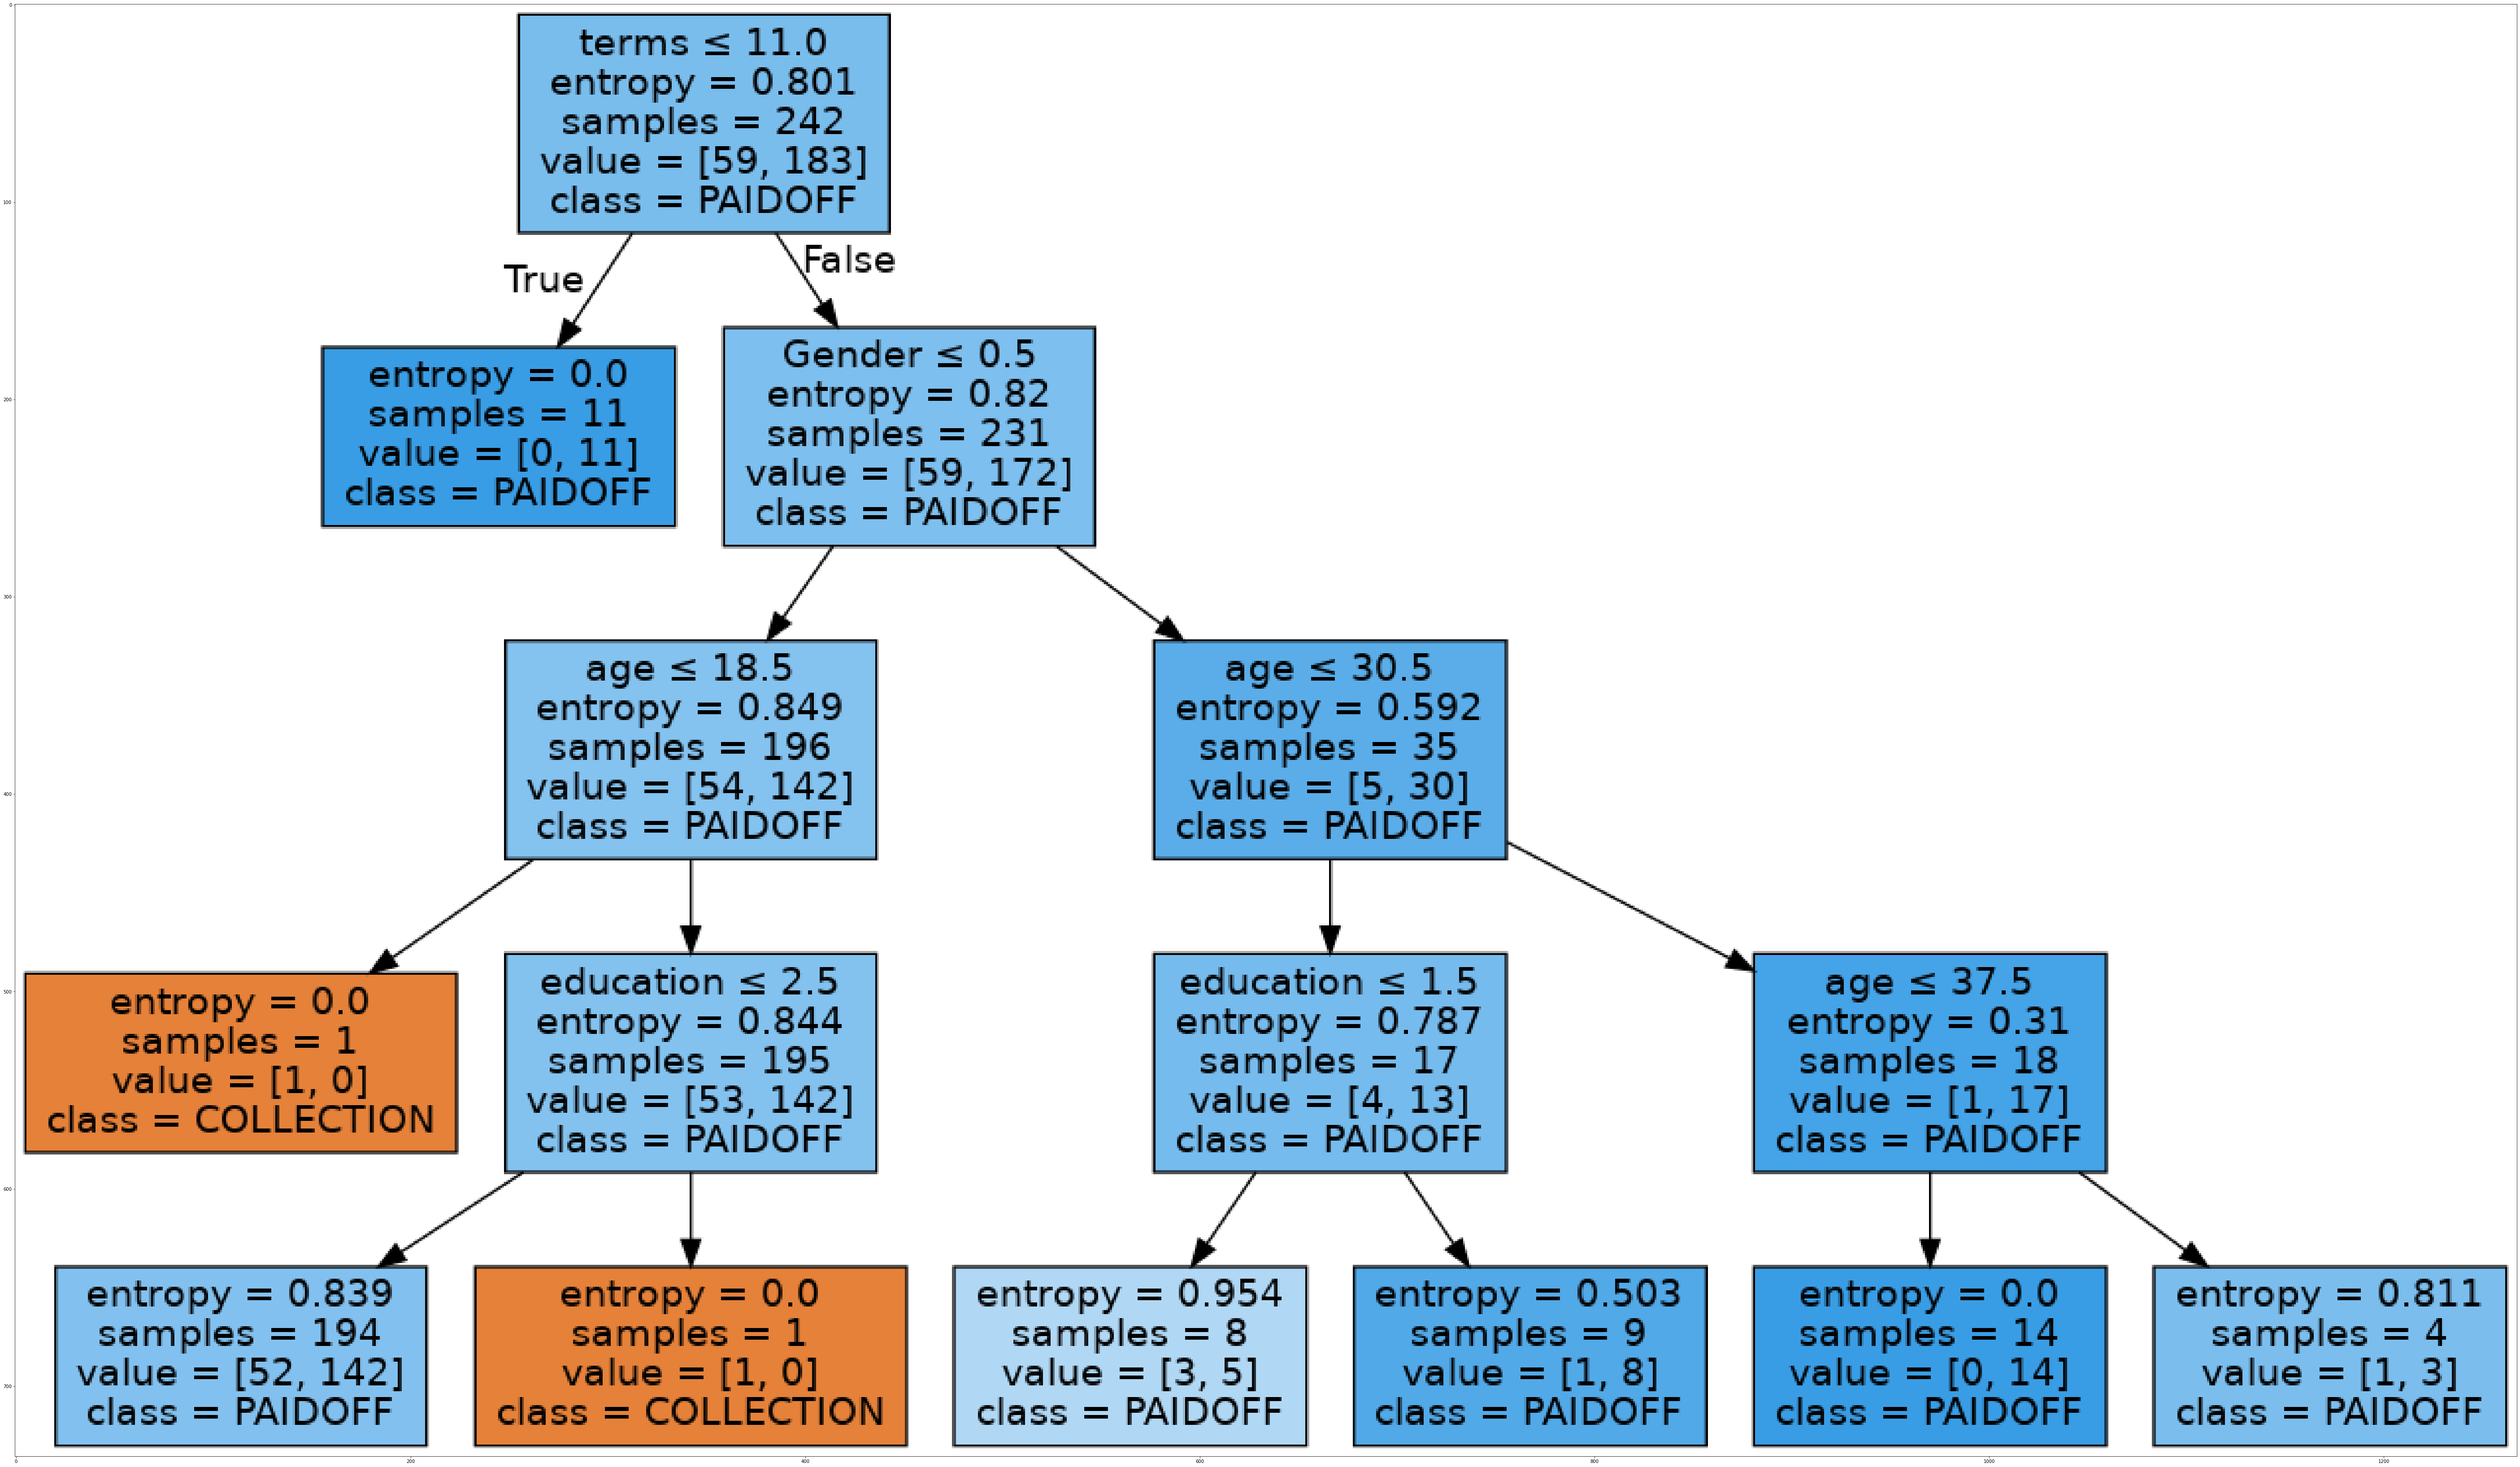

In [831]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:4]
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [833]:
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [844]:
SVM_data = Feature
SVM_data.head()

,terms,age,Gender,education,loan_status
0,30,45,0,1,PAIDOFF
1,30,33,1,0,PAIDOFF
2,15,27,0,2,PAIDOFF
3,30,28,1,2,PAIDOFF
4,30,29,0,2,PAIDOFF


In [846]:
SVM_data['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
SVM_data.head()

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,terms,age,Gender,education,loan_status
0,30,45,0,1,0
1,30,33,1,0,0
2,15,27,0,2,0
3,30,28,1,2,0
4,30,29,0,2,0


In [875]:
SVM_data.dtypes

terms          int64
age            int64
Gender         int64
education      int64
loan_status    int64
dtype: object

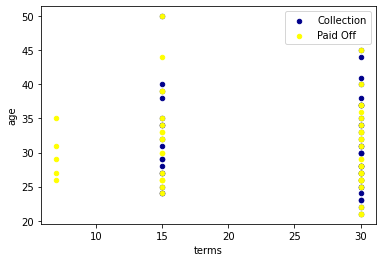

In [859]:
ax = SVM_data[SVM_data['loan_status'] == 1][0:50].plot(kind='scatter', x='terms', y='age', color='DarkBlue', label='Collection');
SVM_data[SVM_data['loan_status'] == 0][0:50].plot(kind='scatter', x='terms', y='age', color='Yellow', label='Paid Off', ax=ax);
plt.show()

In [864]:
SVM_df = SVM_data[['terms','age','Gender','education']]
X_SVM = np.asarray(SVM_df)
X_SVM[0:5]

array([[30, 45,  0,  1],
       [30, 33,  1,  0],
       [15, 27,  0,  2],
       [30, 28,  1,  2],
       [30, 29,  0,  2]])

In [877]:
y_SVM = np.asarray(SVM_data['loan_status'])
y_SVM[0:5]

array([0, 0, 0, 0, 0])

In [878]:
X_train, X_test, y_train, y_test = train_test_split(X_SVM, y_SVM, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 4) (276,)
Test set: (70, 4) (70,)


In [879]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [871]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 0, 0, 0, 0])

In [872]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [880]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


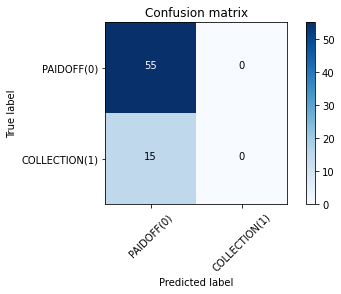

In [881]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

In [882]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6914285714285714

In [885]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.7857142857142857

# Logistic Regression


In [886]:
X_log = X_SVM
X_log[0:5]

array([[30, 45,  0,  1],
       [30, 33,  1,  0],
       [15, 27,  0,  2],
       [30, 28,  1,  2],
       [30, 29,  0,  2]])

In [888]:
y_log = y_SVM
y_log[0:5]

array([0, 0, 0, 0, 0])

In [890]:
X_log = preprocessing.StandardScaler().fit(X_log).transform(X_log)
X_log[0:5]

array([[ 0.92,  2.33, -0.42, -0.45],
       [ 0.92,  0.34,  2.38, -1.89],
       [-0.96, -0.65, -0.42,  0.99],
       [ 0.92, -0.49,  2.38,  0.99],
       [ 0.92, -0.32, -0.42,  0.99]])

In [891]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 4) (276,)
Test set: (70, 4) (70,)


In [892]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [893]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [894]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.57, 0.43],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.6 , 0.4 ],
       [0.59, 0.41],
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.56, 0.44],
       [0.57, 0.43],
       [0.64, 0.36],
       [0.56, 0.44],
       [0.64, 0.36],
       [0.67, 0.33],
       [0.55, 0.45],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.59, 0.41],
       [0.63, 0.37],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.61, 0.39],
       [0.67, 0.33],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.7 , 0.3 ],
       [0.56, 0.44],
       [0.68, 0.32],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.6 , 0.4 ],
       [0.58, 0.42],
       [0.67, 0.33],
       [0.62, 0.38],
       [0.56, 0.44],
       [0.63, 0.37],
       [0.62, 0.38],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.59, 0.41],
       [0.63, 0.37],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.57,

In [895]:
jaccard_score(y_test, yhat,pos_label=0)

0.7857142857142857

In [896]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 0 15]
 [ 0 55]]


Confusion matrix, without normalization
[[55  0]
 [15  0]]


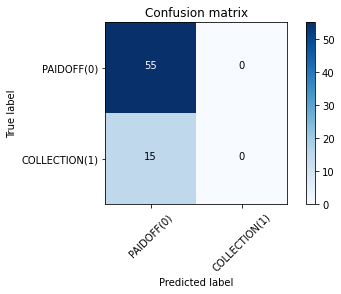

In [897]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

In [898]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [899]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6011992223655565

In [900]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))

LogLoss: : 0.53


# Model Evaluation using Test set


In [928]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [929]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-31 08:29:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-31 08:29:23 (110 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [930]:
# test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [965]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,0,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,0,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,0,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,0,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [966]:
test = test_df[['terms','age','Gender','education','loan_status']]
test.head()

,terms,age,Gender,education,loan_status
0,30,50,1,Bechalor,0
1,7,35,0,Master or Above,0
2,30,43,1,High School or Below,0
3,30,26,0,college,0
4,15,29,0,Bechalor,0


In [967]:
test['education'].replace(to_replace=['Bechalor','High School or Below','college','Master or Above'], value=[0,1,2,3],inplace=True)
test.head()

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,terms,age,Gender,education,loan_status
0,30,50,1,0,0
1,7,35,0,3,0
2,30,43,1,1,0
3,30,26,0,2,0
4,15,29,0,0,0


In [968]:
test_feature = test[['terms','age','Gender','education']]

In [969]:
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)

In [970]:
test_X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [973]:
test_y = test['loan_status'].values
test_y[0:5]

array([0, 0, 0, 0, 0])

In [974]:
# knn_yhat = neigh.predict(test_X)
# print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_y, knn_yhat))
# print("KNN F1-score: %.2f" % f1_score(test_y, knn_yhat, average='weighted') )

In [976]:
# DT_yhat = loanTree.predict(test_X)
# print("DT Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_yhat))
# print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )

In [978]:
# SVM_yhat = clf.predict(test_X)
# print("SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
# print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

In [964]:
# LR_yhat = LR.predict(test_X)
# LR_yhat_prob = LR.predict_proba(test_X)
# print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
# print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
# print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
